In [1]:
import nltk
#nltk.download('stopwords')
from subprocess import check_output
import os
# print(check_output(["ls", os.getcwd()]).decode("utf8"))
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import tensorflow as tf
from collections import Counter

In [2]:
Tweet = pd.read_csv("Tweets.csv")
dtypes = Tweet.dtypes.reset_index()
dtypes
#print(Tweet.dtypes.index) ## get all of the data types in data frame and return index of it.
Tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


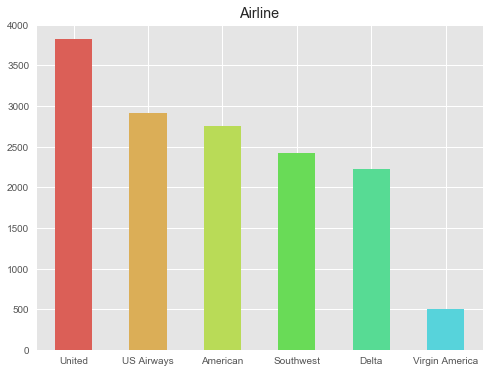

In [3]:
plt.style.use('ggplot')
## count the tweets of every airlines
# airline_counts = Tweet.airline.value_counts().reset_index()
# airline_counts.columns = ['airline', 'counts']
#make the count a plot
colors=sns.color_palette("hls", 10) 
airline_plot = Tweet.airline.value_counts().plot(kind = "bar",color=colors,figsize=(8,6),fontsize=10,rot = 0, 
          title = "Airline")
#plt.savefig('airline.png')

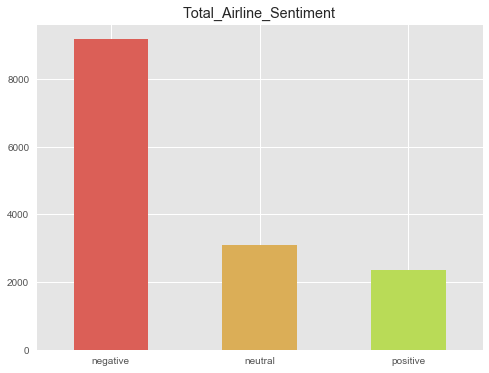

In [4]:
#Tweet.airline_sentiment.value_counts()
colors=sns.color_palette("hls", 10)
pd.Series(Tweet["airline_sentiment"]).value_counts().plot(kind = "bar",color=colors,figsize=(8,6),
          rot=0, title = "Total_Airline_Sentiment")
# plt.savefig('sentiment_count.png')

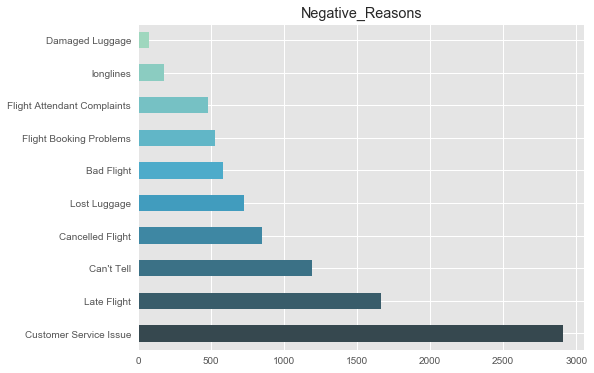

In [5]:
# count the reason of negative evaluation
# Tweet.negativereason.value_counts()
# make it a plot
colors=sns.color_palette("GnBu_d", 10) 
sentiment_count = pd.Series(Tweet["negativereason"]).value_counts().plot(kind = "barh",
            color=colors,figsize=(8,6),title = "Negative_Reasons")

# plt.savefig('airline_sentiment_count.png')

In [6]:
# count the sentiment for all of the airline
air_sen=pd.crosstab(Tweet.airline, Tweet.airline_sentiment)
type(air_sen)
air_sen.dtypes
##get the crosstable of sentiment of arilines

airline_sentiment
negative    int64
neutral     int64
positive    int64
dtype: object

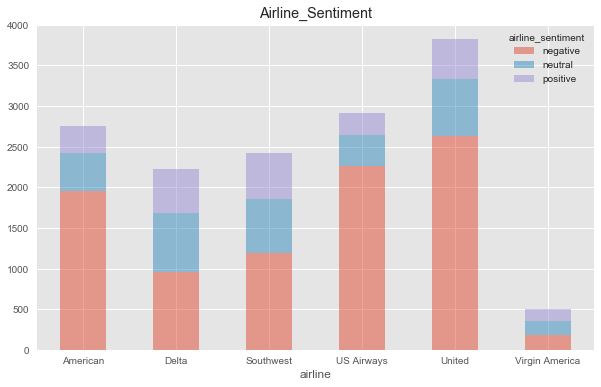

In [7]:
pd.crosstab(index = Tweet["airline"],columns = Tweet["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),
            alpha=0.5,rot=0,stacked=True,title="Airline_Sentiment")
# plt.savefig('comb_sentiment.png')

In [8]:
air_sen.head()
percentage=air_sen.apply(lambda a: a / a.sum() * 100, axis=1)#axis=1 means apply fun to each row, while axis means applying to each column
percentage

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


In [9]:
def tweet_to_words(raw_tweet):##raw_tweet is a original file of tweets data
    letters_only = re.sub("[^a-zA-Z@]", " ",raw_tweet) ##replace @VirginiaAmerica with " " 
    words = letters_only.lower().split()                           
    stops = set(stopwords.words("english"))#set the common words in english  
    meaningful_words = [w for w in words if not w in stops and not re.match("^[@]", w) and not re.match("flight",w)] 
    return( " ".join(meaningful_words)) # add all into a string for every tweets

In [10]:
#Pre-process the tweet and store in a separate column
Tweet['clean_tweet'] = Tweet['text'].apply(lambda x: tweet_to_words(x))

# Join all the words in review to build a corpus
all_text = ' '.join(Tweet['clean_tweet'])#put all the clean_tweet together
words = all_text.split()#split all the sentences into words.
#Convert sentiment to binary output of sentimental analysis
Tweet['sentiment'] = Tweet['airline_sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

#Convert words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)#count the appearance of each word in the text
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} #also, rank the words the put them together;

tweet_ints = []
for each in Tweet['clean_tweet']:
    tweet_ints.append([vocab_to_int[word] for word in each.split()]) # get tweets word rank

#Create a list of labels 
labels = np.array([0 if each == 'negative' else 1 for each in Tweet['airline_sentiment'].values]) 

#Find the number of tweets with zero length after the data pre-processing
tweet_len = Counter([len(x) for x in tweet_ints])
print("Zero-length reviews: {}".format(tweet_len[0]))
print("Maximum review length: {}".format(max(tweet_len)))
#Remove those tweets with zero length and its correspoding label 
tweet_idx  = [idx for idx,tweet in enumerate(tweet_ints) if len(tweet) > 0]#get index for efficient tweets.
labels = labels[tweet_idx]#sentiment of efficient tweet.
Tweet = Tweet.iloc[tweet_idx]#get the efficient tweet and labels in this data structure.
tweet_ints = [tweet for tweet in tweet_ints if len(tweet) > 0]#get word frequency in efficient tweets.

Zero-length reviews: 34
Maximum review length: 22


In [11]:
# create natural language feature model in this section
seq_len = max(tweet_len) # the maximum of a tweets in dataset
features = np.zeros((len(tweet_ints), seq_len), dtype=int)
for i, row in enumerate(tweet_ints):
    features[i, -len(row):] = np.array(row)
features

array([[    0,     0,     0, ...,     0,     0,   122],
       [    0,     0,     0, ...,  2221,   105,  5720],
       [    0,     0,     0, ...,    73,    67,   100],
       ...,
       [    0,     0,     0, ...,   327,   147, 12766],
       [    0,     0,     0, ...,  1283,    48,  2370],
       [    0,     0,     0, ...,   472,    62,    92]])

In [12]:
#split the set into train set, validation set and test set;
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:] # trainset is 80% and validation set is 20%
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)#test set is 10%
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

print("Train set: \t\t{}".format(train_y.shape), 
      "\nValidation set: \t{}".format(val_y.shape),
      "\nTest set: \t\t{}".format(test_y.shape))

			Feature Shapes:
Train set: 		(11684, 22) 
Validation set: 	(1461, 22) 
Test set: 		(1461, 22)
Train set: 		(11684,) 
Validation set: 	(1461,) 
Test set: 		(1461,)


In [27]:
lstm_size = 256
lstm_layers = 1
batch_size = 100
learning_rate = 0.001

In [28]:
#Create input placeholders
n_words = len(vocab_to_int)#vocab_to_int is all word and corresponding rank in the tweet data.
# Create the graph object
graph = tf.Graph()

# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
# Embedding - Efficient way to process the input vector is to do embedding instead of one-hot encoding
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 100   # change embedding size to 100 since we only have small dataset

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

#Build the LSTM cellS// This is default way to construct a LSTM cell model for training
with graph.as_default():
    # Your basic LSTM cell, conditional on the version of the tensorflow
    #if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        #lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, forget_bias=1.0, state_is_tuple=True)
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size, forget_bias=1.0, state_is_tuple=True)
    #else:
        # lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
    #    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    # Add dropout to the cell
    # drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    cell = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    # Stack up multiple LSTM layers, for deep learning ## we may have multiple LSTM layers
    # cell = tf.nn.rnn_cell.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

#RNN Forward pass, get the results of the training graph
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)
    
### Output - Final output of the RNN layer will be used for sentiment prediction. 
### So we need to grab the last output with `outputs[:, -1]`, the calculate the cost from that and `labels_`.
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:,-1], 1, activation_fn=tf.sigmoid)
    cost = tf.contrib.losses.mean_squared_error(labels_, predictions)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) #adam optimizer to train the model
    
## Graph for checking Validation accuracy
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))       

Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.


In [29]:
### Batching - Pick only full batches of data and return based on the batch_size
def get_batches(x, y, batch_size=100):
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [35]:
"""
Train LSTM 
"""
epochs = 5
with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:  # with this session to run tensorflow
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))
                
            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 0.8,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, os.path.join("restore", "twitter_sentiment.ckpt" ))

Epoch: 0/5 Iteration: 5 Train loss: 0.178
Epoch: 0/5 Iteration: 10 Train loss: 0.225
Epoch: 0/5 Iteration: 15 Train loss: 0.146
Epoch: 0/5 Iteration: 20 Train loss: 0.147
Epoch: 0/5 Iteration: 25 Train loss: 0.171
Val acc: 0.718
Epoch: 0/5 Iteration: 30 Train loss: 0.186
Epoch: 0/5 Iteration: 35 Train loss: 0.187
Epoch: 0/5 Iteration: 40 Train loss: 0.178
Epoch: 0/5 Iteration: 45 Train loss: 0.236
Epoch: 0/5 Iteration: 50 Train loss: 0.250
Val acc: 0.507
Epoch: 0/5 Iteration: 55 Train loss: 0.226
Epoch: 0/5 Iteration: 60 Train loss: 0.231
Epoch: 0/5 Iteration: 65 Train loss: 0.237
Epoch: 0/5 Iteration: 70 Train loss: 0.179
Epoch: 0/5 Iteration: 75 Train loss: 0.222
Val acc: 0.671
Epoch: 0/5 Iteration: 80 Train loss: 0.189
Epoch: 0/5 Iteration: 85 Train loss: 0.195
Epoch: 0/5 Iteration: 90 Train loss: 0.210
Epoch: 0/5 Iteration: 95 Train loss: 0.174
Epoch: 0/5 Iteration: 100 Train loss: 0.143
Val acc: 0.746
Epoch: 0/5 Iteration: 105 Train loss: 0.261
Epoch: 0/5 Iteration: 110 Train loss

In [37]:
test_acc = []
test_pred = []

with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('restore'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 0.8,
                initial_state: test_state}
        batch_acc, test_state= sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        prediction = tf.cast(tf.round(predictions),tf.int32)
        prediction = sess.run(prediction,feed_dict=feed)
        test_pred.append(prediction)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from restore/twitter_sentiment.ckpt
Test accuracy: 0.831


In [32]:
##Use the tweet sentiment predicted for the data in the test set,for plotting the wordcloud
test_pred_flat = (np.array(test_pred)).flatten()
start_idx = len(train_x) + len(val_x)
end_idx = start_idx + len(test_pred_flat)+1
Tweet.loc[start_idx:end_idx,'predicted_sentiment'] = test_pred_flat

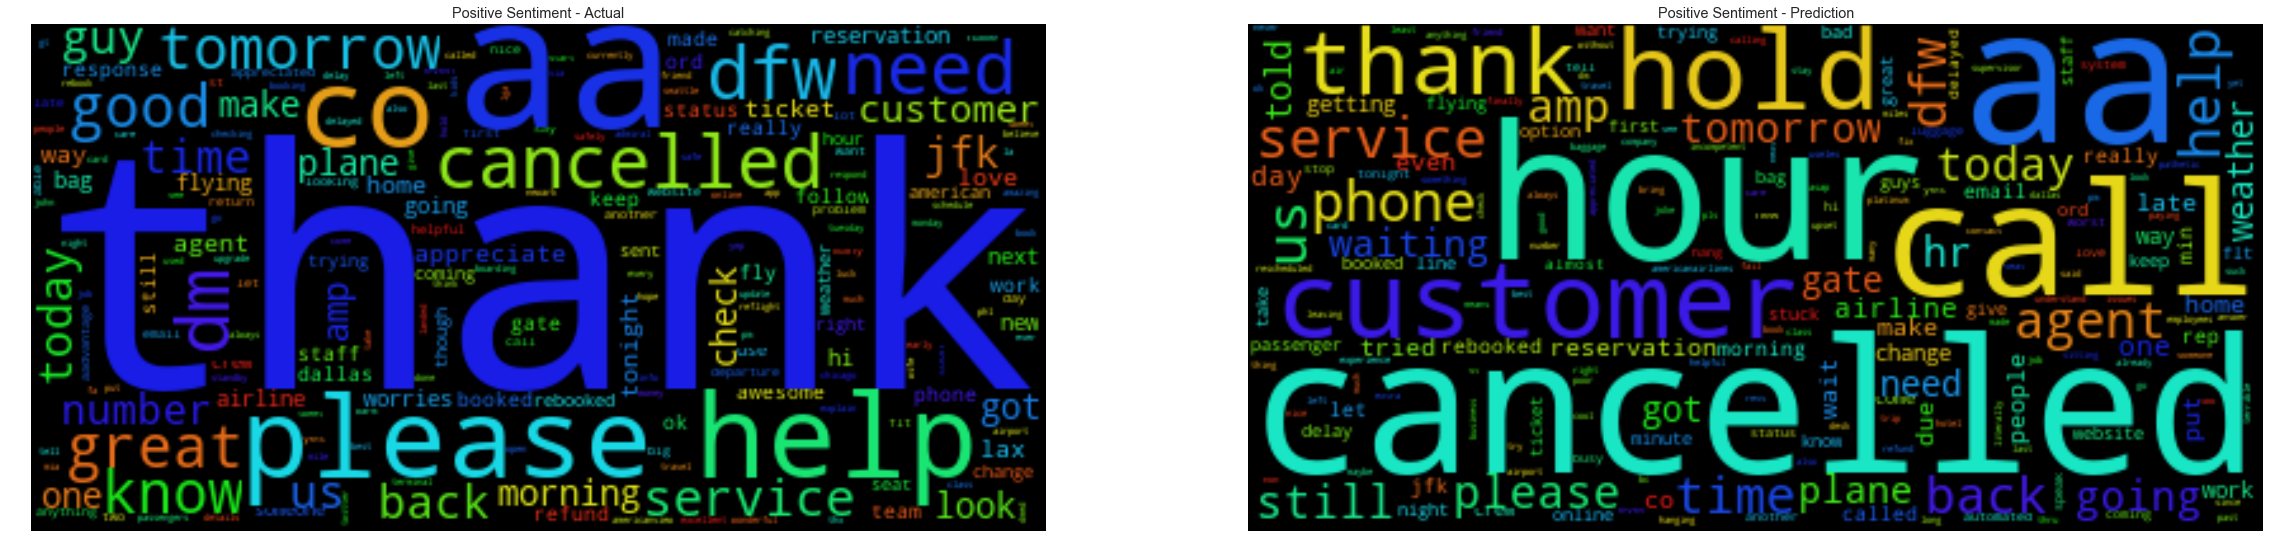

<Figure size 432x288 with 0 Axes>

In [33]:
from os import path
from wordcloud import WordCloud

##Find all the tweets with actual sentiment as "Positive"
start_idx = len(train_x) + len(val_x)
test_tweets = Tweet[start_idx:]
fig = plt.figure( figsize=(40,40))
sub1= fig.add_subplot(2,2,1)

posActualTweets = test_tweets[test_tweets.sentiment==1]
posPredTweets = test_tweets[test_tweets.predicted_sentiment==1]
tweetText = ' '.join((posActualTweets['clean_tweet']))

# Generate a word cloud image
wordcloud = WordCloud().generate(tweetText)
plt.title("Positive Sentiment - Actual")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
sub2= fig.add_subplot(2,2,2)
plt.title("Positive Sentiment - Prediction")
tweetText = ' '.join((posPredTweets['clean_tweet']))
wordcloud = WordCloud().generate(tweetText)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('positive_wordcloud.pdf')

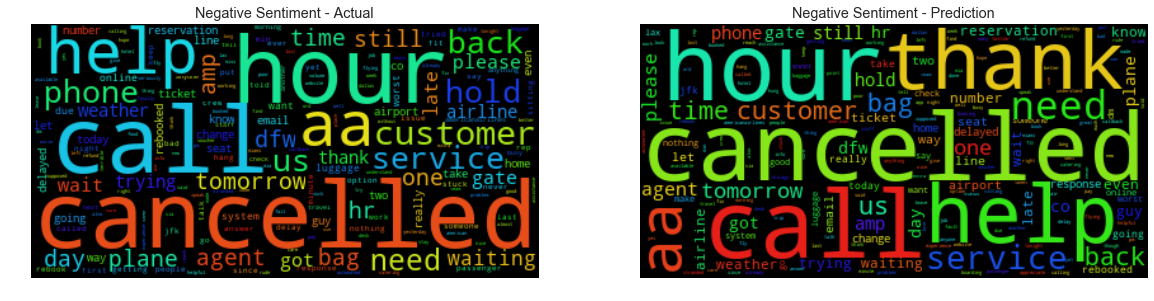

In [34]:
negActualTweets = test_tweets[test_tweets.sentiment!=1]
negPredTweets = test_tweets[test_tweets.predicted_sentiment!=1]

tweetText = ' '.join((negActualTweets['clean_tweet']))

fig = plt.figure( figsize=(20,20))
sub1= fig.add_subplot(2,2,1)
# Generate a word cloud image
wordcloud = WordCloud().generate(tweetText)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative Sentiment - Actual")
plt.axis("off")

sub2= fig.add_subplot(2,2,2)
tweetText = ' '.join((negPredTweets['clean_tweet']))
wordcloud = WordCloud().generate(tweetText)
plt.title("Negative Sentiment - Prediction")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
gru_size = 256
gru_layers = 2 # set GRU layer to 2
batch_size = 100
learning_rate = 0.001

In [22]:
#try GRU in the second case
#Create input placeholders
n_words = len(vocab_to_int)
# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
# Embedding - Efficient way to process the input vector is to do embedding instead of one-hot encoding
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 100
with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_) # word vector input
    
#Build the GRU cellS// This is default way to construct a LSTM cell model for training
gru_cells = []
with graph.as_default():
    # Your basic LSTM cell, conditional on the version of the tensorflow
    for _ in range(gru_layers):
        gru_cell = tf.contrib.rnn.GRUCell(gru_size)
    
        # Add dropout to the cell
        gru_cell = tf.contrib.rnn.DropoutWrapper(gru_cell, output_keep_prob=keep_prob)
           
        # Stack up multiple GRU layers, for deep learning ## we may have multiple LSTM layers
        # cell = tf.nn.rnn_cell.MultiRNNCell([drop] * gru_layers)  #the first version, couldn't accomendate new version
        # gru_cell = tf.contrib.rnn.MultiRNNCell([drop]* gru_layers)   #revised on sep/2018
        gru_cells.append(gru_cell)
        
    gru_cell = tf.contrib.rnn.MultiRNNCell(gru_cells)
    initial_state = gru_cell.zero_state(batch_size, tf.float32)      # Getting an initial state of all zeros

    
    # RNN Forward pass, get the results of the training graph
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(gru_cell, embed, initial_state=initial_state)

### Output - Final output of the RNN layer will be used for sentiment prediction. 
### So we need to grab the last output with `outputs[:, -1]`, the calculate the cost from that and `labels_`.
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    cost = tf.contrib.losses.mean_squared_error(labels_, predictions)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
## Graph for checking Validation accuracy
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.


In [23]:
epochs = 5
with graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, os.path.join("gru","twitter_sentiment_gru.ckpt" ))

Epoch: 0/5 Iteration: 5 Train loss: 0.204
Epoch: 0/5 Iteration: 10 Train loss: 0.200
Epoch: 0/5 Iteration: 15 Train loss: 0.159
Epoch: 0/5 Iteration: 20 Train loss: 0.148
Epoch: 0/5 Iteration: 25 Train loss: 0.167
Val acc: 0.735
Epoch: 0/5 Iteration: 30 Train loss: 0.186
Epoch: 0/5 Iteration: 35 Train loss: 0.202
Epoch: 0/5 Iteration: 40 Train loss: 0.192
Epoch: 0/5 Iteration: 45 Train loss: 0.253
Epoch: 0/5 Iteration: 50 Train loss: 0.267
Val acc: 0.576
Epoch: 0/5 Iteration: 55 Train loss: 0.283
Epoch: 0/5 Iteration: 60 Train loss: 0.180
Epoch: 0/5 Iteration: 65 Train loss: 0.273
Epoch: 0/5 Iteration: 70 Train loss: 0.231
Epoch: 0/5 Iteration: 75 Train loss: 0.236
Val acc: 0.709
Epoch: 0/5 Iteration: 80 Train loss: 0.212
Epoch: 0/5 Iteration: 85 Train loss: 0.228
Epoch: 0/5 Iteration: 90 Train loss: 0.210
Epoch: 0/5 Iteration: 95 Train loss: 0.167
Epoch: 0/5 Iteration: 100 Train loss: 0.127
Val acc: 0.667
Epoch: 0/5 Iteration: 105 Train loss: 0.267
Epoch: 0/5 Iteration: 110 Train loss

In [24]:
test_acc = []
test_pred = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('gru'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state= sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        prediction = tf.cast(tf.round(predictions),tf.int32)
        prediction = sess.run(prediction,feed_dict=feed)
        test_pred.append(prediction)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from gru/twitter_sentiment_gru.ckpt
Test accuracy: 0.841


In [13]:
"""
Use machine learning methods to classify the twitter(including SVM, xgboost, neural network)
I have three different tokenizer methods
1. use bag of words representation to 500 count words
2. use counts matrix in 1 and encode as tf-idf 
3. directly encode texts to tf-idf without delet words
"""
from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
#                             preprocessor = None, 
#                             stop_words = None,   
#                             max_features = 500) 
#train_data_features = vectorizer.fit_transform(Tweet['clean_tweet'])

#from sklearn.feature_extraction.text import TfidfTransformer
#transformer = TfidfTransformer(smooth_idf=False)
#train_data_features = transformer.fit_transform(train_data_features ) # counts is the count of bag of words

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_data_features = vectorizer.fit_transform(Tweet['clean_tweet'])

/Users/Schumi/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [14]:
train_data_features = train_data_features.toarray()
print(train_data_features)
np.shape(train_data_features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(14606, 500)

In [15]:
## split the training set and the test set
split_frac = 0.7
split_idx = int(np.shape(train_data_features)[0]*0.7)
bag_train_x, bag_val_x = train_data_features[:split_idx], train_data_features[split_idx:]
bag_train_y, bag_val_y = Tweet['sentiment'][:split_idx], Tweet['sentiment'][split_idx:]

In [16]:
print ("Training the random forest...")
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10) 
forest = forest.fit(bag_train_x, bag_train_y)
predict = forest.predict(bag_val_x)
##accuracy for the random forest model//
print('Finish training for random forest')
print("The predicion accuracy for random forest is {:.3f}".format(np.mean(bag_val_y == predict)))

Training the random forest...


/Users/Schumi/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Finish training for random forest
The predicion accuracy for random forest is 0.804


In [18]:
####Use neural network to train the data
print ("Training the neural network...")
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 2), random_state=1)
clf.fit(bag_train_x, bag_train_y)                         
nn_predict = clf.predict(bag_val_x)
print("The predicion accuracy for neural network is {:.3f}".format(np.mean(bag_val_y == nn_predict)))

Training the neural network...
The predicion accuracy for neural network is 0.775


In [19]:
####Use SVM to train the data
#### SVM is relatively slow compared to other methods, it is suitable for small datasets
print ("Training SVM...")
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(bag_train_x, bag_train_y)  
svm_predict = svclassifier.predict(bag_val_x)
print("The predicion accuracy for SVM is {:.3f}".format(np.mean(bag_val_y == svm_predict)))

Training SVM...
The predicion accuracy for SVM is 0.730
